In [4]:
import pandas as pd
import numpy as np
import os
from os.path import join, pardir
DATA_DIR = join(pardir, pardir, 'data', 'write', 'gcp_cloud_storage')
DATA_DIR_ZK = join(pardir, pardir, 'data', 'write_zookeeper')

dfs = []
dfs2 = []
for mem in [512, 1024, 2048]:
    
    #for size in [4, 1024, 65536, 131072, 256000]:
    for size in [4, 65536, 131072, 256000]:
        df = pd.read_csv(join(DATA_DIR, f'persistent_{size}_{mem}_processed.csv'), index_col=0)
        df['size'] = size / 1024
        
        #print(df)
        # data is broken :-(
        #df = df.loc[df['memory'] == mem]
        #df = df.groupby(['memory', 'function']).head(150).reset_index(drop=True)
        #if df.shape[0] > 200:
        #    print(size, mem)
        dfs.append(df)
        
        
        zk = pd.read_csv(join(DATA_DIR, f'persistent_{size}_{mem}_processed.csv'), index_col=0)
        
            
        df = pd.read_csv(join(DATA_DIR, f'persistent_{size}_{mem}.csv'), index_col=0)
        #df = df.groupby(['memory', 'size']).head(100).reset_index(drop=True)
        df['size'] = size / 1024
        df['data'] /= 1000.0
        #df.loc[df['op'] == 'set_data', 'data'] /= 1000
        dfs2.append(df)

for size in [4, 1024, 65536, 131072, 256000]:
    df = pd.read_csv(join(DATA_DIR_ZK, f'interregion_{size}.csv'), index_col=0)
    df['data'] /= 1000.0
    df['size'] /= 1024.0
    df['memory'] = 'ZooKeeper'
    dfs2.append(df)

        
dynamo_df = pd.concat(dfs)
dynamo_df['system'] = 'persistent'
dynamo_df_client = pd.concat(dfs2)
dynamo_df_client['system'] = 'persistent'
print(dynamo_df_client.loc[dynamo_df_client['memory'] == 'ZooKeeper'])
print(dynamo_df)



FileNotFoundError: [Errno 2] No such file or directory: '../../data/write/gcp_cloud_storage/persistent_131072_512_processed.csv'

In [119]:
DATA_DIR = join(pardir, pardir, 'data', 'write_new_algorithm')
dfs = []
import ast
# lock atomic commit push rest
#barplot_data = [[],[],[],[],[]]
#barplot_stds = [[],[],[],[],[],[]]
#for size in [4, 1024, 65536, 131072, 256000]:


full_data = []
for size in [4, 1024, 65536, 131072, 256000]:
    
    for memory in [512, 1024, 2048]:
    #for memory in [512]:
        
        with open(join(DATA_DIR, f'persistent_{size}_{memory}.timings')) as in_f:
                  
            writer = False
            for line in in_f:
                
                #print(line.split(':')[2])
                key = line.split(':')[1].split()[0].strip()
                if key == 'total':
                    key = f'{key}_writer' if not writer else f'{key}_distributor'
                    writer = True
                data = ast.literal_eval(line.split(':')[2])
                for val in data:
                    full_data.append([int(size), int(memory), key, val])
        

timings_df = pd.DataFrame(data=full_data, columns=['size', 'memory', 'key', 'value']) 
timings_df['value'] *= 1000
print(timings_df['key'].unique())
#size = 4
#memory = 512
#df = pd.read_csv(join(DATA_DIR, f'persistent_{size}_summary.csv'),index_col=None)
#df['size'] = size / 1024.0
#df['value'] *= 1000.0
#df['value'] /= df['repetitions']
#print(df.loc[(df['memory'] == memory) & (df['function'] == 'writer')])

#barplot_data[0].append(df.loc[(df['memory'] == memory) & (df['function'] == 'writer') & (df['type'] == 'lock')]['value'].values[0])
#barplot_data[1].append(df.loc[(df['memory'] == memory) & (df['function'] == 'writer') & (df['type'] == 'atomic')]['value'].values[0])
#barplot_data[2].append(df.loc[(df['memory'] == memory) & (df['function'] == 'writer') & (df['type'] == 'commit')]['value'].values[0])
#barplot_data[3].append(df.loc[(df['memory'] == memory) & (df['function'] == 'writer') & (df['type'] == 'push')]['value'].values[0])
#total = df.loc[(df['memory'] == memory) & (df['function'] == 'writer') & (df['type'] == 'total')]['value'].values[0]
#barplot_data[4].append(
#    total
#    - barplot_data[0][-1] - barplot_data[1][-1] - barplot_data[2][-1] - barplot_data[3][-1]
#)
barplot_data_writer = [[],[],[],[]]


for size in [4, 65536, 256000]:
    
    for memory in [512, 2048]:
        
        barplot_data_writer[0].append(
            timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'lock')]['value'].median()
        )
        barplot_data_writer[1].append(timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size)& (timings_df['key'] == 'commit')]['value'].median())
        barplot_data_writer[2].append(timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size)& (timings_df['key'] == 'push')]['value'].median())

        total = timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size)& (timings_df['key'] == 'total_writer')]['value'].median()
        #print(total)
        barplot_data_writer[3].append(
            total
            - barplot_data_writer[0][-1] - barplot_data_writer[1][-1] - barplot_data_writer[2][-1]
        )
        
barplot_data_distributor = [[],[],[],[],[]]


for size in [4, 65536, 256000]:
    
    for memory in [512, 2048]:
        
        barplot_data_distributor[0].append(
            timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'exec_read')]['value'].median()
            + timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'exec_update')]['value'].median()
        )
        #barplot_data_distributor[1].append(
        #    timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'exec_update')]['value'].median()
        #)
        barplot_data_distributor[1].append(
            timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'exec_pop_updates')]['value'].median()
        )
        barplot_data_distributor[2].append(timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size)& (timings_df['key'] == 'watch_query')]['value'].median())
        barplot_data_distributor[3].append(timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size)& (timings_df['key'] == 'notify')]['value'].median())

        total = timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size)& (timings_df['key'] == 'total_distributor')]['value'].median()
        #print(total)
        barplot_data_distributor[4].append(
            total
            - barplot_data_distributor[0][-1] - barplot_data_distributor[1][-1] - barplot_data_distributor[2][-1] - barplot_data_distributor[3][-1]
        )

['lock' 'push' 'commit' 'total_writer' 'parse' 'write' 'watch_query'
 'notify' 'watch_notify' 'total_distributor' 'exec_read' 'exec_update'
 'exec_pop_updates']


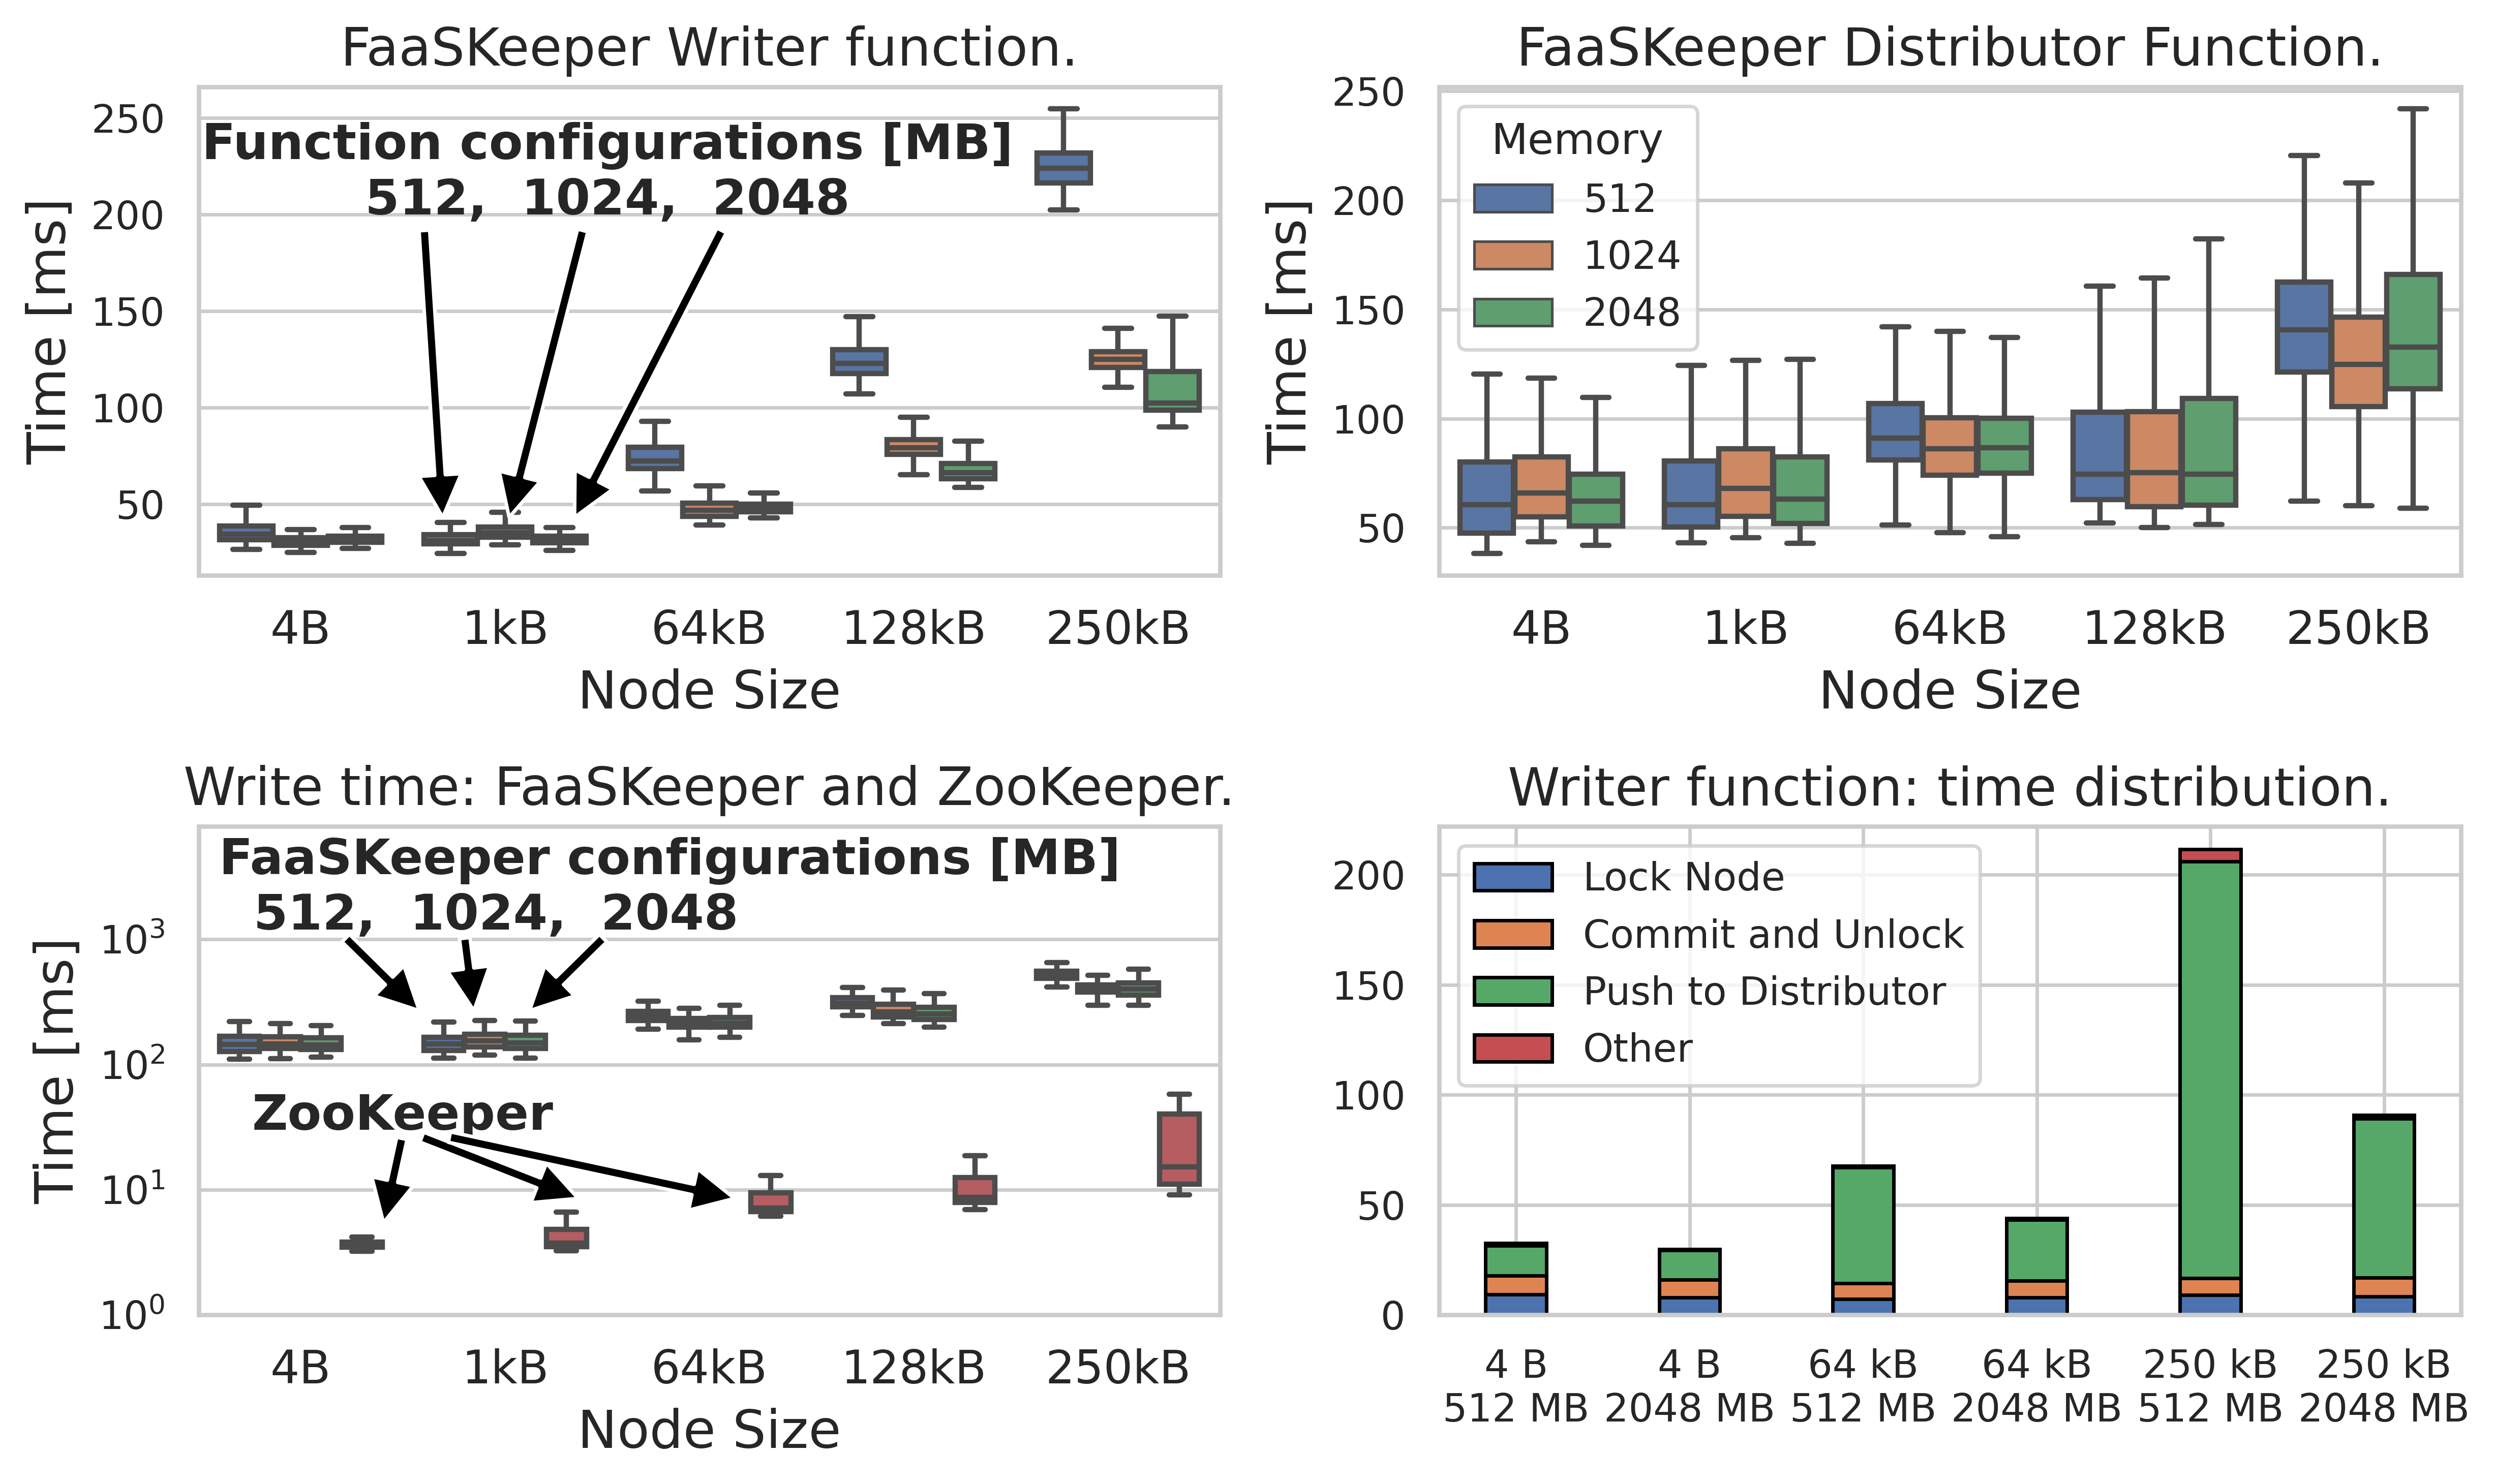

In [58]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats
from os.path import join, pardir

DATA_DIR = join(pardir, pardir, 'data', 'read')

#sns.set(rc={'figure.figsize':(16,8)})
sns.set(rc={'figure.figsize':(10,6)})
sns.set_style("whitegrid")

fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(2,4)
writer = fig3.add_subplot(gs[0, 0:2])
distr1 = fig3.add_subplot(gs[0, 2:4])
total = fig3.add_subplot(gs[1, 0:2])
barplot = fig3.add_subplot(gs[1,2:4])

# Draw a nested barplot by species and sex
dynamo_df.rename(columns={'memory': 'Memory'}, inplace=True)
#print(dynamo_df)
g = sns.boxplot(x="size", y="time",
            hue="Memory", #palette=["m", "g"],
            data=dynamo_df.loc[dynamo_df['function']=='writer'], ax=writer,showfliers=False)

handles, labels = g.get_legend_handles_labels()
#g.legend().set_visible(False)
#(handles, [f"{m} MB" for m in labels], fontsize=7, ncol=2) #, bbox_to_anchor=(-0.03, -0.45), loc='lower center', handletextpad=0.4, fontsize=20)

g.set_xticklabels( ('4B', '1kB','64kB', '128kB', '250kB') )
g.set_xlabel('Node Size',fontsize=15)
g.set_ylabel('Time [ms]',fontsize=15)
g.set_title('FaaSKeeper Writer function.', fontsize=15)
g.tick_params(axis='x', labelsize=13)
#g.set_yscale('log')
g.legend().set_visible(False)

#for xtick in g.get_xticks():
#    print(xtick)
#    g.text(xtick,100,'100', horizontalalignment='center')#,size='x-small',color='w',weight='semibold')
                  #medians[xtick] + vertical_offset,medians[xtick], 
            #horizontalalignment='center',size='x-small',color='w',weight='semibold')

g.annotate('Function configurations [MB]\n512,  1024,  2048',fontweight='bold',
            xy=(1.5, 200), xytext=(1.5, 200), fontsize=14, ha='center')
g.annotate('', fontweight='bold',
            xy=(0.7, 35), xytext=(0.6, 200), fontsize=14,
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(1, 35), xytext=(1.4, 200), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(1.3, 35), xytext=(2.1, 200), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')

# Draw a nested barplot by species and sex
g = sns.boxplot(x="size", y="time",
            hue="Memory", #palette=["m", "g"],
            data=dynamo_df.loc[dynamo_df['function']=='distributor'], ax=distr1,showfliers=False)
handles, labels = g.get_legend_handles_labels()
#g.legend().set_visible(False)
g.tick_params(axis='x', labelsize=13)


#g.legend(handles, [f"{m} MB" for m in labels], fontsize=7, ncol=2) #, bbox_to_anchor=(-0.03, -0.45), loc='lower center', handletextpad=0.4, fontsize=20)
g.set_xticklabels( ('4B', '1kB','64kB', '128kB', '250kB') )
g.set_xlabel('Node Size',fontsize=15)
g.set_ylabel('Time [ms]',fontsize=15)
g.set_title('FaaSKeeper Distributor Function.', fontsize=15)

#s3_df_client['data']/=1000.0
# Draw a nested barplot by species and sex
g = sns.boxplot(x="size", y="data",
            hue="memory", #palette=["m", "g"],
            data=dynamo_df_client.loc[dynamo_df_client['op']=='set_data'], ax=total,showfliers=False)
handles, labels = g.get_legend_handles_labels()

g.legend(handles, ['512 MB', '1024 MB', '2048 MB', 'ZooKeeper'], loc='upper left',ncol=2) #, bbox_to_anchor=(-0.03, -0.45), loc='lower center', handletextpad=0.4, fontsize=20)
g.set_xticklabels( ('4B', '1kB','64kB', '128kB', '250kB') )
g.set_xlabel('Node Size',fontsize=15)
g.set_ylabel('Time [ms]',fontsize=15)
g.set_title('Write time: FaaSKeeper and ZooKeeper.', fontsize=15)
g.set_yscale('log')
g.set_ylim(1, 8000)
g.legend().set_visible(False)
g.tick_params(axis='x', labelsize=13)


#g.annotate('Functions: 512 MB, 1024 MB\nand 2048 MB.',
#            xy=(0.7, 250), xytext=(0, 1000), fontsize=12, fontweight='bold',
#            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='left')
g.annotate('FaaSKeeper configurations [MB]\n  512,  1024,  2048', fontweight='bold',
            xy=(0, 1000), xytext=(-0.4, 1200), fontsize=14, ha='left')
g.annotate('',
            xy=(0.85, 250), xytext=(0.8, 1100), fontsize=14, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(1.1, 250), xytext=(1.5, 1100), fontsize=14, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(0.6, 250), xytext=(0.2, 1100), fontsize=14, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')

g.annotate('ZooKeeper', fontweight='bold',
            xy=(0, 1000), xytext=(0.5, 30), fontsize=14, ha='center')
g.annotate('',
            xy=(0.4, 5), xytext=(0.5, 28), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(1.4, 8), xytext=(0.55, 28), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(2.2, 8), xytext=(0.65, 28), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')


width = 0.35       # the width of the bars: can also be len(x) sequence
sum_ = [0,0,0,0,0,0]
labels = ['4 B\n512 MB', '4 B\n2048 MB', '64 kB\n512 MB', '64 kB\n2048 MB', '250 kB\n512 MB', '250 kB\n2048 MB']
for id, col in enumerate(['Lock Node', 'Commit and Unlock', 'Push to Distributor', 'Other']):

    #print(barplot_data[id])
    barplot.bar(labels, barplot_data_writer[id], width, label=col, bottom=sum_, edgecolor='black')
    sum_ = np.add(sum_, barplot_data_writer[id])
barplot.legend()

barplot.set_title('Writer function: time distribution.', fontsize=15)
#barplot.tick_params(axis='x', labelsize=12)

plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig("new_plot_small_2x2_log.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

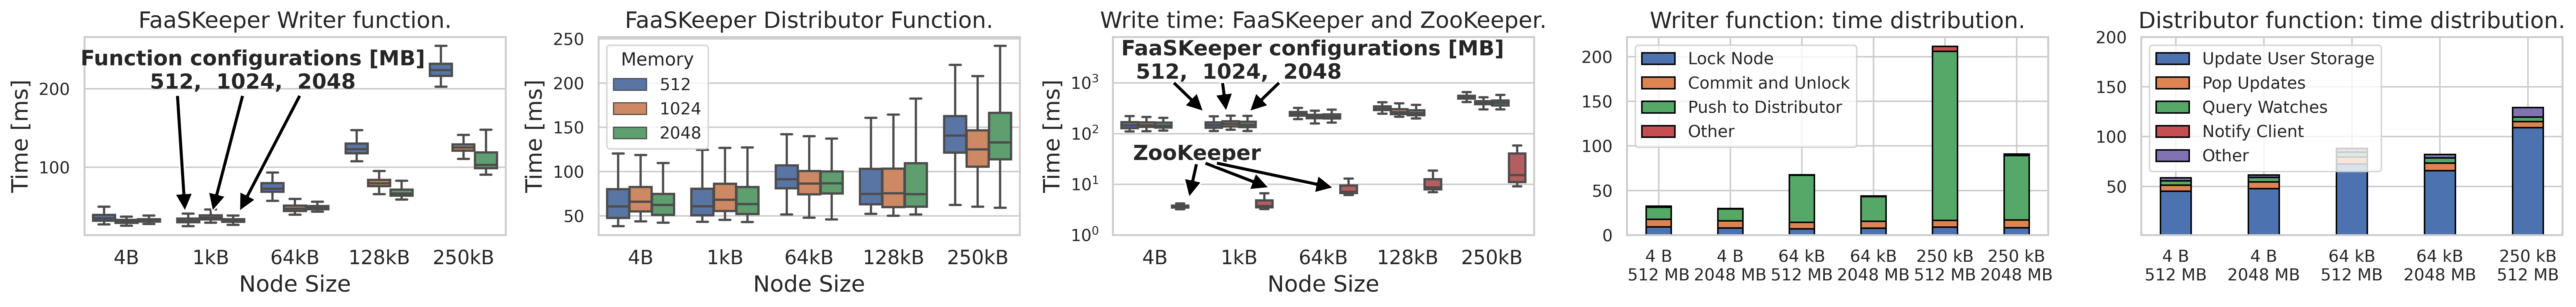

In [75]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats
from os.path import join, pardir

DATA_DIR = join(pardir, pardir, 'data', 'read')

#sns.set(rc={'figure.figsize':(16,8)})
sns.set(rc={'figure.figsize':(24,4)})
sns.set_style("whitegrid")

fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(1,10)
writer = fig3.add_subplot(gs[0, 0:2])
distr1 = fig3.add_subplot(gs[0, 2:4])
total = fig3.add_subplot(gs[0, 4:6])
barplot = fig3.add_subplot(gs[0,6:8])
barplot_distr = fig3.add_subplot(gs[0,8:10])

# Draw a nested barplot by species and sex
dynamo_df.rename(columns={'memory': 'Memory'}, inplace=True)
#print(dynamo_df)
g = sns.boxplot(x="size", y="time",
            hue="Memory", #palette=["m", "g"],
            data=dynamo_df.loc[dynamo_df['function']=='writer'], ax=writer,showfliers=False)

handles, labels = g.get_legend_handles_labels()
#g.legend().set_visible(False)
#(handles, [f"{m} MB" for m in labels], fontsize=7, ncol=2) #, bbox_to_anchor=(-0.03, -0.45), loc='lower center', handletextpad=0.4, fontsize=20)

g.set_xticklabels( ('4B', '1kB','64kB', '128kB', '250kB') )
g.set_xlabel('Node Size',fontsize=15)
g.set_ylabel('Time [ms]',fontsize=15)
g.set_title('FaaSKeeper Writer function.', fontsize=15)
g.tick_params(axis='x', labelsize=13)
#g.set_yscale('log')
g.legend().set_visible(False)

#for xtick in g.get_xticks():
#    print(xtick)
#    g.text(xtick,100,'100', horizontalalignment='center')#,size='x-small',color='w',weight='semibold')
                  #medians[xtick] + vertical_offset,medians[xtick], 
            #horizontalalignment='center',size='x-small',color='w',weight='semibold')

g.annotate('Function configurations [MB]\n512,  1024,  2048',fontweight='bold',
            xy=(1.5, 200), xytext=(1.5, 200), fontsize=14, ha='center')
g.annotate('', fontweight='bold',
            xy=(0.7, 35), xytext=(0.6, 200), fontsize=14,
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(1, 35), xytext=(1.4, 200), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(1.3, 35), xytext=(2.1, 200), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')

# Draw a nested barplot by species and sex
g = sns.boxplot(x="size", y="time",
            hue="Memory", #palette=["m", "g"],
            data=dynamo_df.loc[dynamo_df['function']=='distributor'], ax=distr1,showfliers=False)
handles, labels = g.get_legend_handles_labels()
#g.legend().set_visible(False)
g.tick_params(axis='x', labelsize=13)


#g.legend(handles, [f"{m} MB" for m in labels], fontsize=7, ncol=2) #, bbox_to_anchor=(-0.03, -0.45), loc='lower center', handletextpad=0.4, fontsize=20)
g.set_xticklabels( ('4B', '1kB','64kB', '128kB', '250kB') )
g.set_xlabel('Node Size',fontsize=15)
g.set_ylabel('Time [ms]',fontsize=15)
g.set_title('FaaSKeeper Distributor Function.', fontsize=15)

#s3_df_client['data']/=1000.0
# Draw a nested barplot by species and sex
g = sns.boxplot(x="size", y="data",
            hue="memory", #palette=["m", "g"],
            data=dynamo_df_client.loc[dynamo_df_client['op']=='set_data'], ax=total,showfliers=False)
handles, labels = g.get_legend_handles_labels()

g.legend(handles, ['512 MB', '1024 MB', '2048 MB', 'ZooKeeper'], loc='upper left',ncol=2) #, bbox_to_anchor=(-0.03, -0.45), loc='lower center', handletextpad=0.4, fontsize=20)
g.set_xticklabels( ('4B', '1kB','64kB', '128kB', '250kB') )
g.set_xlabel('Node Size',fontsize=15)
g.set_ylabel('Time [ms]',fontsize=15)
g.set_title('Write time: FaaSKeeper and ZooKeeper.', fontsize=15)
g.set_yscale('log')
g.set_ylim(1, 8000)
g.legend().set_visible(False)
g.tick_params(axis='x', labelsize=13)


#g.annotate('Functions: 512 MB, 1024 MB\nand 2048 MB.',
#            xy=(0.7, 250), xytext=(0, 1000), fontsize=12, fontweight='bold',
#            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='left')
g.annotate('FaaSKeeper configurations [MB]\n  512,  1024,  2048', fontweight='bold',
            xy=(0, 1000), xytext=(-0.4, 1200), fontsize=14, ha='left')
g.annotate('',
            xy=(0.85, 250), xytext=(0.8, 1100), fontsize=14, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(1.1, 250), xytext=(1.5, 1100), fontsize=14, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(0.6, 250), xytext=(0.2, 1100), fontsize=14, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')

g.annotate('ZooKeeper', fontweight='bold',
            xy=(0, 1000), xytext=(0.5, 30), fontsize=14, ha='center')
g.annotate('',
            xy=(0.4, 5), xytext=(0.5, 28), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(1.4, 8), xytext=(0.55, 28), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(2.2, 8), xytext=(0.65, 28), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')


width = 0.35       # the width of the bars: can also be len(x) sequence
sum_ = [0,0,0,0,0,0]
labels = ['4 B\n512 MB', '4 B\n2048 MB', '64 kB\n512 MB', '64 kB\n2048 MB', '250 kB\n512 MB', '250 kB\n2048 MB']
for id, col in enumerate(['Lock Node', 'Commit and Unlock', 'Push to Distributor', 'Other']):

    #print(barplot_data[id])
    barplot.bar(labels, barplot_data_writer[id], width, label=col, bottom=sum_, edgecolor='black')
    sum_ = np.add(sum_, barplot_data_writer[id])
barplot.legend()

barplot.set_title('Writer function: time distribution.', fontsize=15)



width = 0.35       # the width of the bars: can also be len(x) sequence
sum_ = [0,0,0,0,0,0]
labels = ['4 B\n512 MB', '4 B\n2048 MB', '64 kB\n512 MB', '64 kB\n2048 MB', '250 kB\n512 MB', '250 kB\n2048 MB']
for id, col in enumerate(['Update User Storage', 'Pop Updates', 'Query Watches', 'Notify Client', 'Other']):

    #print(barplot_data[id])
    barplot_distr.bar(labels, barplot_data_distributor[id], width, label=col, bottom=sum_, edgecolor='black')
    sum_ = np.add(sum_, barplot_data_distributor[id])
barplot_distr.legend(loc='upper left')
barplot_distr.set_ylim(1, 200)

barplot_distr.set_title('Distributor function: time distribution.', fontsize=15)

#barplot.tick_params(axis='x', labelsize=12)

plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig("new_plot_small_1x5_log.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

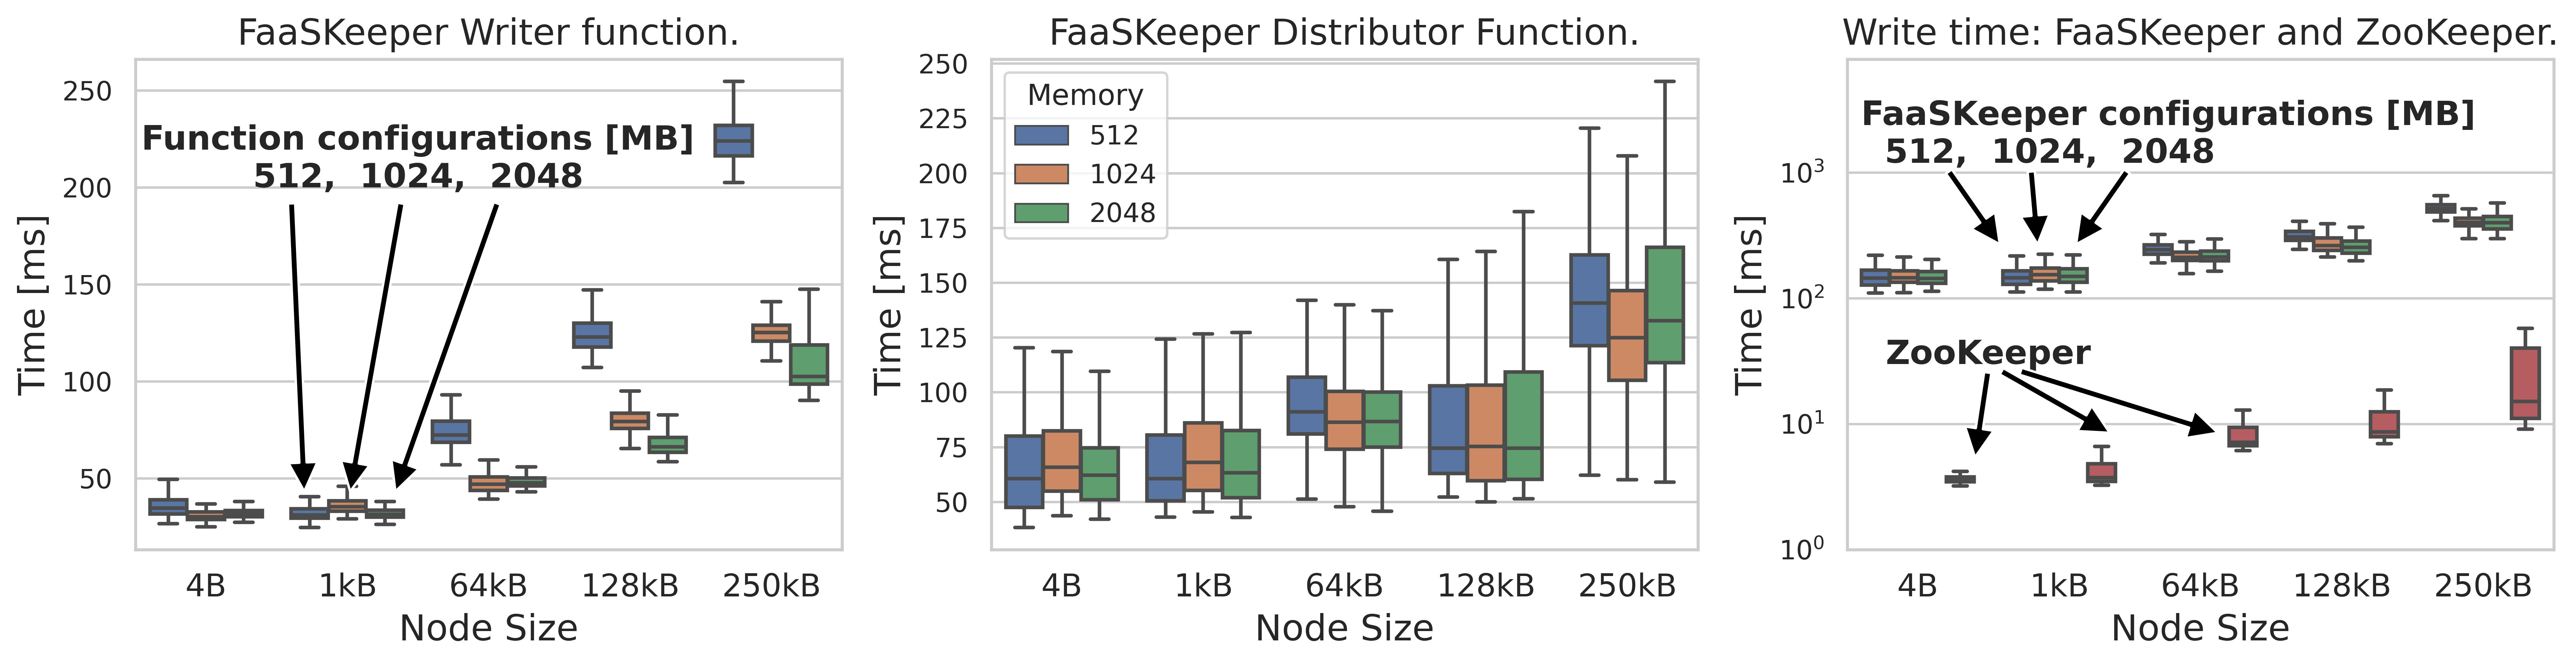

In [126]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats
from os.path import join, pardir

DATA_DIR = join(pardir, pardir, 'data', 'read')

#sns.set(rc={'figure.figsize':(16,8)})
sns.set(rc={'figure.figsize':(15,4)})
sns.set_style("whitegrid")

fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(1,6)
writer = fig3.add_subplot(gs[0, 0:2])
distr1 = fig3.add_subplot(gs[0, 2:4])
total = fig3.add_subplot(gs[0, 4:6])

# Draw a nested barplot by species and sex
dynamo_df.rename(columns={'memory': 'Memory'}, inplace=True)
#print(dynamo_df)
g = sns.boxplot(x="size", y="time",
            hue="Memory", #palette=["m", "g"],
            data=dynamo_df.loc[dynamo_df['function']=='writer'], ax=writer,showfliers=False)

handles, labels = g.get_legend_handles_labels()
#g.legend().set_visible(False)
#(handles, [f"{m} MB" for m in labels], fontsize=7, ncol=2) #, bbox_to_anchor=(-0.03, -0.45), loc='lower center', handletextpad=0.4, fontsize=20)

g.set_xticklabels( ('4B', '1kB','64kB', '128kB', '250kB') )
g.set_xlabel('Node Size',fontsize=15)
g.set_ylabel('Time [ms]',fontsize=15)
g.set_title('FaaSKeeper Writer function.', fontsize=15)
g.tick_params(axis='x', labelsize=13)
#g.set_yscale('log')
g.legend().set_visible(False)

#for xtick in g.get_xticks():
#    print(xtick)
#    g.text(xtick,100,'100', horizontalalignment='center')#,size='x-small',color='w',weight='semibold')
                  #medians[xtick] + vertical_offset,medians[xtick], 
            #horizontalalignment='center',size='x-small',color='w',weight='semibold')

g.annotate('Function configurations [MB]\n512,  1024,  2048',fontweight='bold',
            xy=(1.5, 200), xytext=(1.5, 200), fontsize=14, ha='center')
g.annotate('', fontweight='bold',
            xy=(0.7, 35), xytext=(0.6, 200), fontsize=14,
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(1, 35), xytext=(1.4, 200), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(1.3, 35), xytext=(2.1, 200), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')

# Draw a nested barplot by species and sex
g = sns.boxplot(x="size", y="time",
            hue="Memory", #palette=["m", "g"],
            data=dynamo_df.loc[dynamo_df['function']=='distributor'], ax=distr1,showfliers=False)
handles, labels = g.get_legend_handles_labels()
#g.legend().set_visible(False)
g.tick_params(axis='x', labelsize=13)


#g.legend(handles, [f"{m} MB" for m in labels], fontsize=7, ncol=2) #, bbox_to_anchor=(-0.03, -0.45), loc='lower center', handletextpad=0.4, fontsize=20)
g.set_xticklabels( ('4B', '1kB','64kB', '128kB', '250kB') )
g.set_xlabel('Node Size',fontsize=15)
g.set_ylabel('Time [ms]',fontsize=15)
g.set_title('FaaSKeeper Distributor Function.', fontsize=15)

#s3_df_client['data']/=1000.0
# Draw a nested barplot by species and sex
g = sns.boxplot(x="size", y="data",
            hue="memory", #palette=["m", "g"],
            data=dynamo_df_client.loc[dynamo_df_client['op']=='set_data'], ax=total,showfliers=False)
handles, labels = g.get_legend_handles_labels()

g.legend(handles, ['512 MB', '1024 MB', '2048 MB', 'ZooKeeper'], loc='upper left',ncol=2) #, bbox_to_anchor=(-0.03, -0.45), loc='lower center', handletextpad=0.4, fontsize=20)
g.set_xticklabels( ('4B', '1kB','64kB', '128kB', '250kB') )
g.set_xlabel('Node Size',fontsize=15)
g.set_ylabel('Time [ms]',fontsize=15)
g.set_title('Write time: FaaSKeeper and ZooKeeper.', fontsize=15)
g.set_yscale('log')
g.set_ylim(1, 8000)
g.legend().set_visible(False)
g.tick_params(axis='x', labelsize=13)


#g.annotate('Functions: 512 MB, 1024 MB\nand 2048 MB.',
#            xy=(0.7, 250), xytext=(0, 1000), fontsize=12, fontweight='bold',
#            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='left')
g.annotate('FaaSKeeper configurations [MB]\n  512,  1024,  2048', fontweight='bold',
            xy=(0, 1000), xytext=(-0.4, 1200), fontsize=14, ha='left')
g.annotate('',
            xy=(0.85, 250), xytext=(0.8, 1100), fontsize=14, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(1.1, 250), xytext=(1.5, 1100), fontsize=14, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(0.6, 250), xytext=(0.2, 1100), fontsize=14, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')

g.annotate('ZooKeeper', fontweight='bold',
            xy=(0, 1000), xytext=(0.5, 30), fontsize=14, ha='center')
g.annotate('',
            xy=(0.4, 5), xytext=(0.5, 28), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(1.4, 8), xytext=(0.55, 28), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(2.2, 8), xytext=(0.65, 28), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')

plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig("new_plot_small_1x3_log.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

[9.252190589904785, 8.016109466552734, 7.154583930969238, 7.843971252441406, 9.09268856048584, 8.359432220458984]
[8.596658706665039, 7.932901382446289, 7.121801376342773, 7.674574851989746, 7.555723190307617, 8.585929870605469]
[13.515353202819824, 13.349533081054688, 52.80601978302002, 27.72808074951172, 189.34237957000732, 72.18217849731445]
[1.1459589004516602, 0.5167722702026367, 0.6235837936401367, 0.662684440612793, 5.452752113342285, 1.6455650329589844]


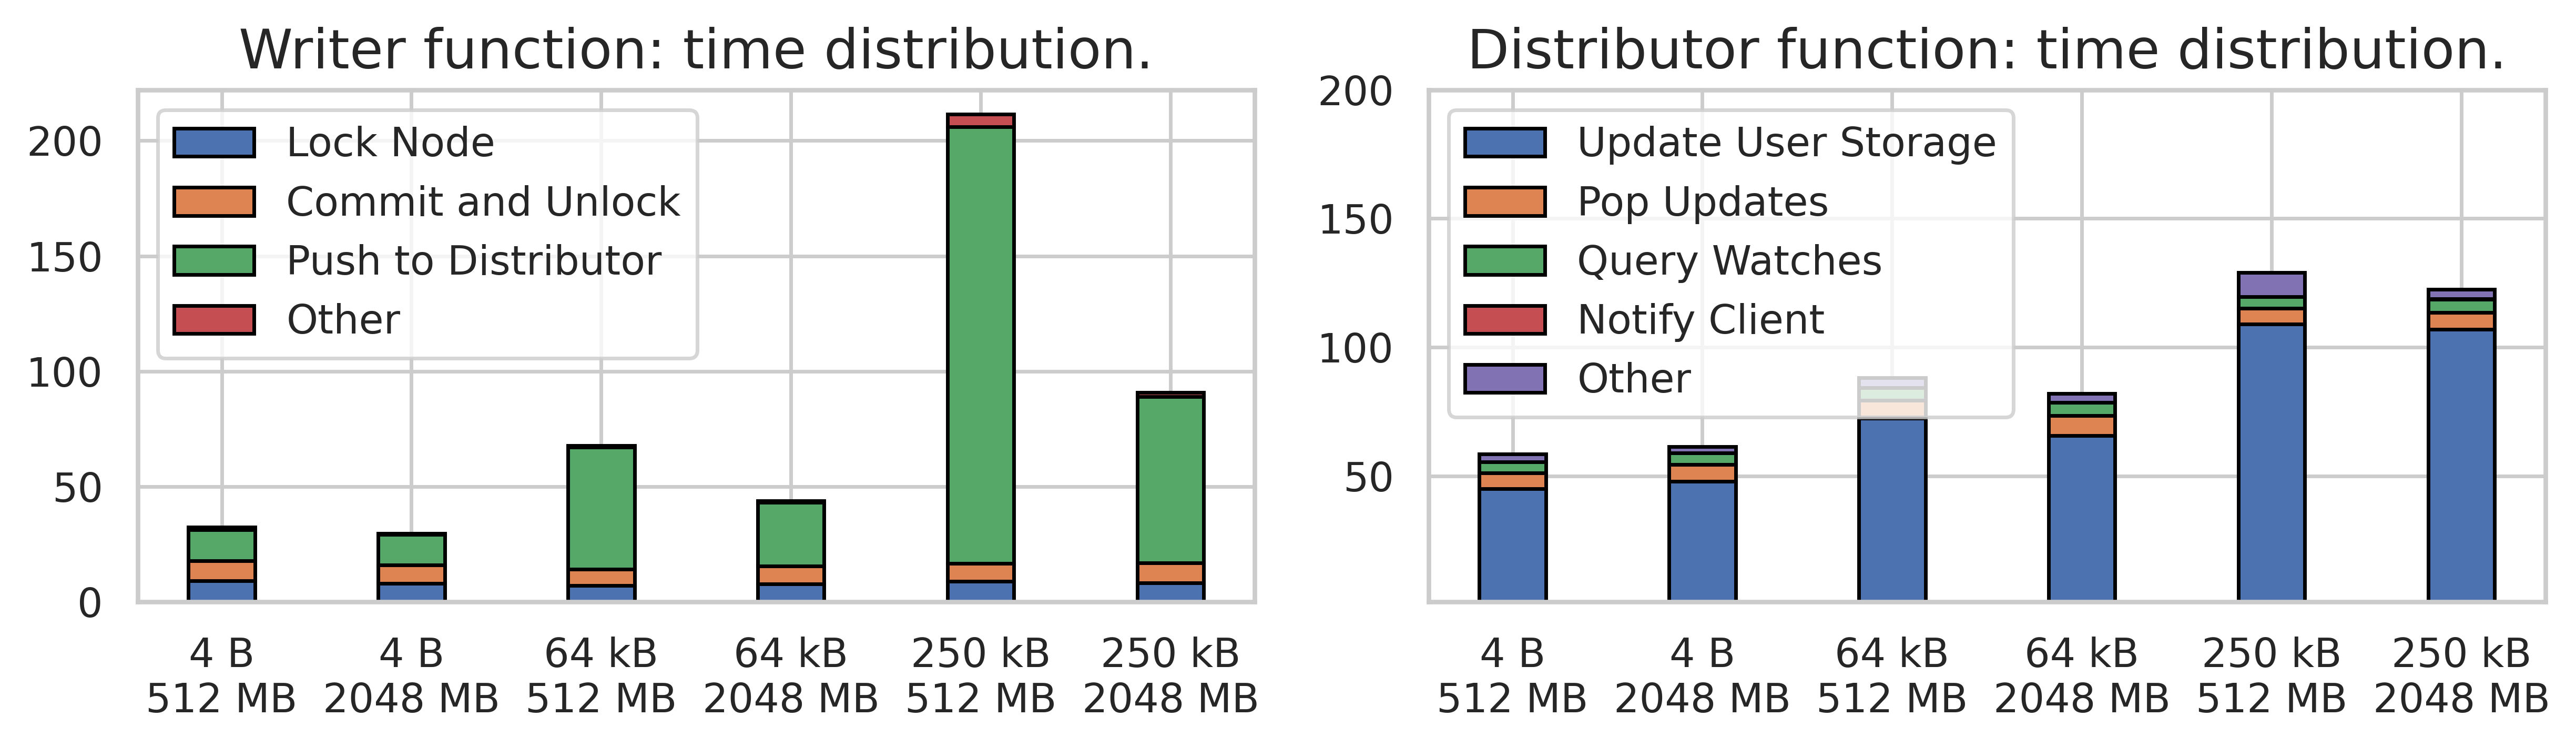

In [116]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats
from os.path import join, pardir

DATA_DIR = join(pardir, pardir, 'data', 'read')

#sns.set(rc={'figure.figsize':(16,8)})
sns.set(rc={'figure.figsize':(10,3)})
sns.set_style("whitegrid")

fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(1,4)
barplot = fig3.add_subplot(gs[0,0:2])
barplot_distr = fig3.add_subplot(gs[0,2:4])

width = 0.35       # the width of the bars: can also be len(x) sequence
sum_ = [0,0,0,0,0,0]
labels = ['4 B\n512 MB', '4 B\n2048 MB', '64 kB\n512 MB', '64 kB\n2048 MB', '250 kB\n512 MB', '250 kB\n2048 MB']
for id, col in enumerate(['Lock Node', 'Commit and Unlock', 'Push to Distributor', 'Other']):

    print(barplot_data_writer[id])
    barplot.bar(labels, barplot_data_writer[id], width, label=col, bottom=sum_, edgecolor='black')
    sum_ = np.add(sum_, barplot_data_writer[id])
barplot.legend()

barplot.set_title('Writer function: time distribution.', fontsize=15)


width = 0.35       # the width of the bars: can also be len(x) sequence
sum_ = [0,0,0,0,0,0]
labels = ['4 B\n512 MB', '4 B\n2048 MB', '64 kB\n512 MB', '64 kB\n2048 MB', '250 kB\n512 MB', '250 kB\n2048 MB']
for id, col in enumerate(['Update User Storage', 'Pop Updates', 'Query Watches', 'Notify Client', 'Other']):

    #print(barplot_data[id])
    barplot_distr.bar(labels, barplot_data_distributor[id], width, label=col, bottom=sum_, edgecolor='black')
    sum_ = np.add(sum_, barplot_data_distributor[id])
barplot_distr.legend(loc='upper left')
barplot_distr.set_ylim(1, 200)

barplot_distr.set_title('Distributor function: time distribution.', fontsize=15)

plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig("new_plot_small_1x2_log.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

## Analysis of variability

In [78]:
DATA_DIR = join(pardir, pardir, 'data', 'write_new_algorithm')
dfs = []
import ast
# lock atomic commit push rest
#barplot_data = [[],[],[],[],[]]
#barplot_stds = [[],[],[],[],[],[]]
#for size in [4, 1024, 65536, 131072, 256000]:


full_data = []
for size in [4, 1024, 65536, 131072, 256000]:
    
    for memory in [512, 1024, 2048]:
    #for memory in [512]:
        
        with open(join(DATA_DIR, f'persistent_{size}_{memory}.timings')) as in_f:
                  
            writer = False
            for line in in_f:
                
                #print(line.split(':')[2])
                key = line.split(':')[1].split()[0].strip()
                if key == 'total':
                    key = f'{key}_writer' if not writer else f'{key}_distributor'
                    writer = True
                data = ast.literal_eval(line.split(':')[2])
                for val in data:
                    full_data.append([int(size), int(memory), key, val])
        

timings_df = pd.DataFrame(data=full_data, columns=['size', 'memory', 'key', 'value']) 
timings_df['value'] *= 1000

['lock' 'push' 'commit' 'total_writer' 'parse' 'write' 'watch_query'
 'notify' 'watch_notify' 'total_distributor' 'exec_read' 'exec_update'
 'exec_pop_updates']


In [107]:
# compute the writer statistics

def get_data(series):
    
    return (
        series.min(),
        series.median(),
        series.quantile(0.9),
        series.quantile(0.95),
        series.quantile(0.99),
        series.max()
    )

for size in [4, 65536, 256000]:
    
    for memory in [512, 2048]:
        
        d = get_data(dynamo_df.loc[(dynamo_df['Memory'] == memory) & (dynamo_df['function'] == 'writer') & (dynamo_df['size'] == size/1024.0)]['time'])
        print(memory, ' & ', size, *[f' & {round(x, 2)}' for x in d])
        

512  &  4  &   & 26.68  & 34.56  & 45.46  & 50.68  & 78.48  & 83.33
2048  &  4  &   & 27.29  & 31.81  & 38.55  & 41.88  & 58.78  & 63.24
512  &  65536  &   & 48.53  & 72.33  & 87.5  & 91.6  & 118.3  & 132.4
2048  &  65536  &   & 32.55  & 47.76  & 55.35  & 63.26  & 90.41  & 122.57
512  &  256000  &   & 31.99  & 223.95  & 239.12  & 243.66  & 270.17  & 295.04
2048  &  256000  &   & 30.24  & 102.53  & 142.35  & 163.15  & 183.49  & 223.17


In [108]:
# compute the writer statistics for detailed information

def get_data(series):
    
    return (
        series.min(),
        series.median(),
        series.quantile(0.9),
        series.quantile(0.95),
        series.quantile(0.99),
        series.max()
    )

for size in [4, 65536, 256000]:
    
    for memory in [2048]:
        
        lock_data = get_data(
            timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'lock')]['value']
        )
        commit_data = get_data(
            timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'commit')]['value']
        )
        push_data = get_data(
            timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'push')]['value']
        )
        print(size, *[f' & {round(x, 2)}' for x in lock_data])
        print(size, *[f' & {round(x, 2)}' for x in commit_data])
        print(size, *[f' & {round(x, 2)}' for x in push_data])
        

4  & 7.38  & 8.02  & 9.47  & 12.69  & 26.8  & 52.1
4  & 7.31  & 7.93  & 9.41  & 11.91  & 26.83  & 82.71
4  & 9.65  & 13.35  & 15.55  & 17.28  & 38.15  & 56.07
65536  & 7.2  & 7.84  & 9.28  & 10.14  & 18.13  & 18.76
65536  & 7.09  & 7.67  & 9.61  & 11.74  & 14.27  & 84.61
65536  & 23.56  & 27.73  & 30.83  & 33.63  & 58.62  & 81.77
256000  & 6.77  & 8.36  & 15.38  & 17.79  & 28.48  & 69.64
256000  & 6.61  & 8.59  & 14.31  & 18.81  & 32.83  & 63.67
256000  & 62.73  & 72.18  & 96.82  & 118.62  & 148.61  & 176.44


In [112]:
# compute the distributor statistics 

def get_data(series):
    
    return (
        series.min(),
        series.median(),
        series.quantile(0.9),
        series.quantile(0.95),
        series.quantile(0.99),
        series.max()
    )

for size in [4, 65536, 256000]:
    
    for memory in [2048]:
        
        d = get_data(dynamo_df.loc[(dynamo_df['Memory'] == memory) & (dynamo_df['function'] == 'distributor') & (dynamo_df['size'] == size/1024.0)]['time'])
        print(size, *[f' & {round(x, 2)}' for x in d])
        

4  & 42.02  & 62.16  & 92.01  & 103.65  & 138.28  & 151.4
65536  & 45.78  & 86.62  & 124.58  & 138.18  & 181.74  & 257.05
256000  & 58.94  & 132.62  & 213.5  & 294.01  & 465.47  & 1166.05


In [122]:
# compute the writer statistics for detailed information

def get_data(series):
    
    return (
        series.min(),
        series.median(),
        series.quantile(0.9),
        series.quantile(0.95),
        series.quantile(0.99)
    )

for size in [4, 65536, 256000]:
    
    for memory in [2048]:
        
        data = []
        
        lock_data = get_data(
            timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'exec_read')]['value']
        )
        commit_data = get_data(
            timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'exec_update')]['value']
        )
        push_data = get_data(
            timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'watch_query')]['value']
        )
        print(size, *[f' & {round(x, 2)}' for x in lock_data])
        print(size, *[f' & {round(x, 2)}' for x in commit_data])
        print(size, *[f' & {round(x, 2)}' for x in push_data])
        

4  & 4.67  & 5.09  & 5.68  & 6.92  & 11.83
4  & 24.4  & 42.73  & 70.7  & 84.94  & 118.13
4  & 3.88  & 4.48  & 5.45  & 7.0  & 28.64
65536  & 4.71  & 6.08  & 10.01  & 13.52  & 20.55
65536  & 25.07  & 59.64  & 94.47  & 105.3  & 142.42
65536  & 4.69  & 5.06  & 5.98  & 7.01  & 21.96
256000  & 4.58  & 4.97  & 7.31  & 11.13  & 19.83
256000  & 32.51  & 102.07  & 183.17  & 265.42  & 432.92
256000  & 4.68  & 5.13  & 6.76  & 7.59  & 18.38


## Final plot with cost

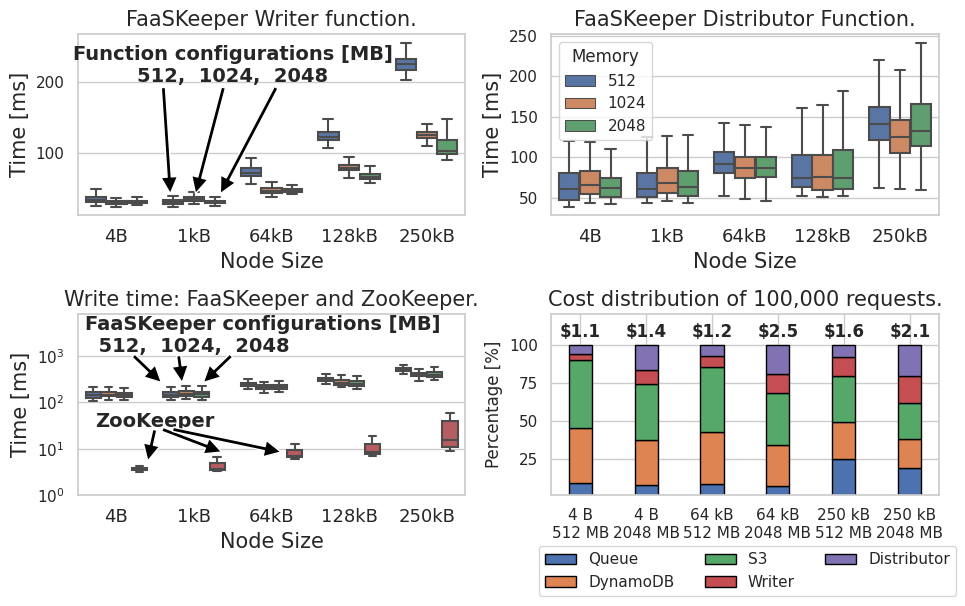

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats
from os.path import join, pardir

DATA_DIR = join(pardir, pardir, 'data', 'read')

#sns.set(rc={'figure.figsize':(16,8)})
sns.set(rc={'figure.figsize':(10,6.5)})
sns.set_style("whitegrid")

fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(2,4)
writer1 = fig3.add_subplot(gs[0, 0:2])
distr1 = fig3.add_subplot(gs[0, 2:4])
total = fig3.add_subplot(gs[1, 0:2])
total_cost = fig3.add_subplot(gs[1, 2:4])

# Draw a nested barplot by species and sex
dynamo_df.rename(columns={'memory': 'Memory'}, inplace=True)
#print(dynamo_df)
g = sns.boxplot(x="size", y="time",
            hue="Memory", #palette=["m", "g"],
            data=dynamo_df.loc[dynamo_df['function']=='writer'], ax=writer1,showfliers=False)

handles, labels = g.get_legend_handles_labels()
#g.legend().set_visible(False)
#(handles, [f"{m} MB" for m in labels], fontsize=7, ncol=2) #, bbox_to_anchor=(-0.03, -0.45), loc='lower center', handletextpad=0.4, fontsize=20)

g.set_xticklabels( ('4B', '1kB','64kB', '128kB', '250kB') )
g.set_xlabel('Node Size',fontsize=15)
g.set_ylabel('Time [ms]',fontsize=15)
g.set_title('FaaSKeeper Writer function.', fontsize=15)
g.tick_params(axis='x', labelsize=13)
#g.set_yscale('log')
g.legend().set_visible(False)

#for xtick in g.get_xticks():
#    print(xtick)
#    g.text(xtick,100,'100', horizontalalignment='center')#,size='x-small',color='w',weight='semibold')
                  #medians[xtick] + vertical_offset,medians[xtick], 
            #horizontalalignment='center',size='x-small',color='w',weight='semibold')

g.annotate('Function configurations [MB]\n512,  1024,  2048',fontweight='bold',
            xy=(1.5, 200), xytext=(1.5, 200), fontsize=14, ha='center')
g.annotate('', fontweight='bold',
            xy=(0.7, 35), xytext=(0.6, 200), fontsize=14,
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(1, 35), xytext=(1.4, 200), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(1.3, 35), xytext=(2.1, 200), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')

# Draw a nested barplot by species and sex
g = sns.boxplot(x="size", y="time",
            hue="Memory", #palette=["m", "g"],
            data=dynamo_df.loc[dynamo_df['function']=='distributor'], ax=distr1,showfliers=False)
handles, labels = g.get_legend_handles_labels()
#g.legend().set_visible(False)
g.tick_params(axis='x', labelsize=13)


#g.legend(handles, [f"{m} MB" for m in labels], fontsize=7, ncol=2) #, bbox_to_anchor=(-0.03, -0.45), loc='lower center', handletextpad=0.4, fontsize=20)
g.set_xticklabels( ('4B', '1kB','64kB', '128kB', '250kB') )
g.set_xlabel('Node Size',fontsize=15)
g.set_ylabel('Time [ms]',fontsize=15)
g.set_title('FaaSKeeper Distributor Function.', fontsize=15)

#s3_df_client['data']/=1000.0
# Draw a nested barplot by species and sex
g = sns.boxplot(x="size", y="data",
            hue="memory", #palette=["m", "g"],
            data=dynamo_df_client.loc[dynamo_df_client['op']=='set_data'], ax=total,showfliers=False)
handles, labels = g.get_legend_handles_labels()

g.legend(handles, ['512 MB', '1024 MB', '2048 MB', 'ZooKeeper'], loc='upper left',ncol=2) #, bbox_to_anchor=(-0.03, -0.45), loc='lower center', handletextpad=0.4, fontsize=20)
g.set_xticklabels( ('4B', '1kB','64kB', '128kB', '250kB') )
g.set_xlabel('Node Size',fontsize=15)
g.set_ylabel('Time [ms]',fontsize=15)
g.set_title('Write time: FaaSKeeper and ZooKeeper.', fontsize=15)
g.set_yscale('log')
g.set_ylim(1, 8000)
g.legend().set_visible(False)
g.tick_params(axis='x', labelsize=13)


#g.annotate('Functions: 512 MB, 1024 MB\nand 2048 MB.',
#            xy=(0.7, 250), xytext=(0, 1000), fontsize=12, fontweight='bold',
#            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='left')
g.annotate('FaaSKeeper configurations [MB]\n  512,  1024,  2048', fontweight='bold',
            xy=(0, 1000), xytext=(-0.4, 1200), fontsize=14, ha='left')
g.annotate('',
            xy=(0.85, 250), xytext=(0.8, 1100), fontsize=14, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(1.1, 250), xytext=(1.5, 1100), fontsize=14, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(0.6, 250), xytext=(0.2, 1100), fontsize=14, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')

g.annotate('ZooKeeper', fontweight='bold',
            xy=(0, 1000), xytext=(0.5, 30), fontsize=14, ha='center')
g.annotate('',
            xy=(0.4, 5), xytext=(0.5, 28), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(1.4, 8), xytext=(0.55, 28), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')
g.annotate('',
            xy=(2.2, 8), xytext=(0.65, 28), fontsize=12, fontweight='bold',
            arrowprops=dict(facecolor='black', shrink=0.05, width=3,lw=1), ha='center')



width = 0.35       # the width of the bars: can also be len(x) sequence
sum_ = [0,0,0,0,0,0]
labels = ['4 B\n512 MB', '4 B\n2048 MB', '64 kB\n512 MB', '64 kB\n2048 MB', '250 kB\n512 MB', '250 kB\n2048 MB']
for id, col in enumerate(['Queue', 'DynamoDB', 'S3', 'Writer', 'Distributor']):

    #print(barplot_data[id])
    total_cost.bar(labels, cost_data[id], width, label=col, bottom=sum_, edgecolor='black')
    sum_ = np.add(sum_, cost_data[id])
total_cost.legend(loc='upper left')
total_cost.set_ylabel('Percentage [%]')
total_cost.legend(bbox_to_anchor=(-0.05, -0.6), ncols=3,loc="lower left")
total_cost.annotate('$1.1', xy=(0.0, 105), ha='center', fontweight='bold')
total_cost.annotate('$1.4', xy=(1, 105), ha='center', fontweight='bold')
total_cost.annotate('$1.2', xy=(2, 105), ha='center', fontweight='bold')
total_cost.annotate('$2.5', xy=(3, 105), ha='center', fontweight='bold')
total_cost.annotate('$1.6', xy=(4, 105), ha='center', fontweight='bold')
total_cost.annotate('$2.1', xy=(5, 105), ha='center', fontweight='bold')
total_cost.set_ylim(1, 120)

total_cost.set_title('Cost distribution of 100,000 requests.', fontsize=15)

plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig("new_plot_small_2x2_log.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

In [13]:
import math
# PUT, COPY, POST, LIST requests (per 1,000 requests)
def write_s3(s):
    return  5*10**-6
def read_s3(s):
    return  0.4*10**-6
def write_dynamodb(s):
    return math.ceil(s) * 1.25 * 10**-6
def read_dynamodb(s):
    return math.ceil(s/4.0) * 0.25 * 10**-6
# FIFO Queues (per Million requests) 0.5
def sqs(s):
    return math.ceil(s/64.0) * 0.5 * 10**-6

lambda_const = 1.66667 * 10**-5

def writer(m, s):
    return lambda_const*(coefficients['writer'][m][0] * s + coefficients['writer'][m][1]) + 0.2 * 10**-6
def writer_time(m, s):
    return coefficients['writer'][m][0] * s + coefficients['writer'][m][1]
def distributor(m, s):
    return lambda_const*(coefficients['distributor'][m][0] * s + coefficients['distributor'][m][1]) + 0.2 * 10**-6
def distributor_time(m, s):
    return coefficients['distributor'][m][0] * s + coefficients['distributor'][m][1]

def total_cost(m, s):
    return 2 * sqs(s) + 3 * write_dynamodb(1) + read_dynamodb(1) + write_s3(s) + writer(m, s) + distributor(m, s)


In [8]:
import numpy as np
import pandas as pd
import os
from os.path import join, pardir
DATA_DIR = join(pardir, pardir, 'data', 'write_new_algorithm')

dfs = []
for mem in [512, 1024, 2048]:
    
    for size in [4, 1024, 65536, 131072, 256000]:
        df = pd.read_csv(join(DATA_DIR, f'persistent_{size}_{mem}_processed.csv'), index_col=0)
        df['size'] = size / 1024
        
        #print(df)
        # data is broken :-(
        #df = df.loc[df['memory'] == mem]
        #df = df.groupby(['memory', 'function']).head(150).reset_index(drop=True)
        #if df.shape[0] > 200:
        #    print(size, mem)
        dfs.append(df)
        
        
dynamo_df = pd.concat(dfs)
dynamo_df['system'] = 'persistent'
dynamo_df['gbs'] = dynamo_df['billed_time'] * dynamo_df['memory'] / 1024.0 / 1000
#print(dynamo_df)
#print(dynamo_df.groupby(['function', 'memory', 'size']).median()['gbs'])
#for memory in [512, 1024, 2048]

data = {}
for f in ['writer', 'distributor']:
    data[f] = {}
    for m in [512, 1024, 2048]:
        data[f][m] = []

for name, group in dynamo_df.groupby(['function', 'memory', 'size']):
    data[name[0]][name[1]].append(group['gbs'].median())
print(data)

import numpy as np
from sklearn.linear_model import LinearRegression

#r_sq = model.score(x, y)
#print('coefficient of determination:', r_sq)

coefficients = {}

x = np.array([0.003906, 1.000000, 64, 128, 250]).reshape((-1, 1))
for f in ['writer', 'distributor']:
    coefficients[f] = {}
    for m in [512, 1024, 2048]:
        y = data[f][m]
        model = LinearRegression().fit(x, y)
        print(f, m, model.score(x, y))
        print(f, m, model.intercept_)
        print(f, m, model.coef_)
        coefficients[f][m] = (model.coef_[0], model.intercept_)

{'writer': {512: [0.0175, 0.016, 0.0365, 0.0615, 0.112], 1024: [0.031, 0.036, 0.0475, 0.08, 0.126], 2048: [0.064, 0.064, 0.096, 0.134, 0.206]}, 'distributor': {512: [0.0305, 0.0305, 0.046, 0.0375, 0.0705], 1024: [0.066, 0.068, 0.087, 0.076, 0.1255], 2048: [0.126, 0.128, 0.174, 0.15, 0.266]}}
writer 512 0.9963644802244943
writer 512 0.014966494004788104
writer 512 [0.00038074]
writer 1024 0.9871717634314536
writer 1024 0.03083290883434315
writer 1024 [0.00037547]
writer 2048 0.9989504094603819
writer 2048 0.06237247873913875
writer 2048 [0.00056915]
distributor 512 0.8323095564630623
distributor 512 0.03013358333813803
distributor 512 [0.00014522]
distributor 1024 0.8340794980527049
distributor 1024 0.06564661349131273
distributor 1024 [0.00021279]
distributor 2048 0.8446768498912897
distributor 2048 0.12385090667403802
distributor 2048 [0.00050732]


In [4]:

cost_data = [[], [], [], [], []]

# queue
# DynamoDB ops
# S3 write
# Writer
# Distributor
requests = 10**5
for size in [0.003906, 64, 250]:
    
    for memory in [512,  2048]:
        
        #print(size, memory, cost_data,2 * sqs(size) * requests)
        cost_data[0].append( 2 * sqs(size) * requests )
        cost_data[1].append( (3 * write_dynamodb(1) + read_dynamodb(1))* requests  )
        cost_data[2].append( write_s3(size) * requests )
        cost_data[3].append( writer(memory, size) * requests )
        cost_data[4].append( distributor(memory, size)* requests )
        
        
        #print(size, memory, 2 * sqs(size) * requests , (3 * write_dynamodb(1) + read_dynamodb(1))* requests ,write_s3(size) * requests,writer(memory, size) * requests,distributor(memory, size) * requests)
        
        sum_ = 0
        for i in range(5):
            sum_ += cost_data[i][-1]
        for i in range(5):
            cost_data[i][-1] = cost_data[i][-1] / sum_ *100
        print(size, memory, round(sum_, 1))
        
print(cost_data)

0.003906 512 1.1
0.003906 2048 1.4
64 512 1.2
64 2048 1.5
250 512 1.6
250 2048 2.1
[[8.967239688363883, 7.405323288112023, 8.537749810368569, 6.825019559574021, 24.475088515108258, 19.057551719225234], [35.86895875345553, 29.621293152448093, 34.150999241474274, 27.300078238296084, 24.475088515108258, 19.057551719225234], [44.836198441819406, 37.02661644056012, 42.68874905184285, 34.125097797870104, 30.593860643885325, 23.821939649031542], [4.030476990199856, 9.17949392518186, 7.3045680314014625, 12.603371821603748, 12.456872805368407, 17.204322258662344], [6.297126126161334, 16.767273193697925, 7.317933864912843, 19.14643258265606, 7.999089520529758, 20.85863465385565]]


In [14]:
print(total_cost(2048, 250)*100000)
print(writer_time(2048, 250))
print(writer(2048, 250)*100000)
print(distributor(2048, 250)*100000)

2.098905493702428
0.20466106970266074
0.3611024650413336
0.43780302866109466


[86.18712425231934, 105.65698146820068, 89.80333805084229, 81.55477046966553, 80.39307594299316, 87.6246690750122]
[0.6052255630493164, 0.6015300750732422, 0.8827447891235352, 0.8476972579956055, 3.3718347549438477, 3.341555595397949]
[0.2065896987915039, 0.22876262664794922, 1.3794898986816406, 1.3424158096313477, 5.639076232910156, 6.358146667480469]


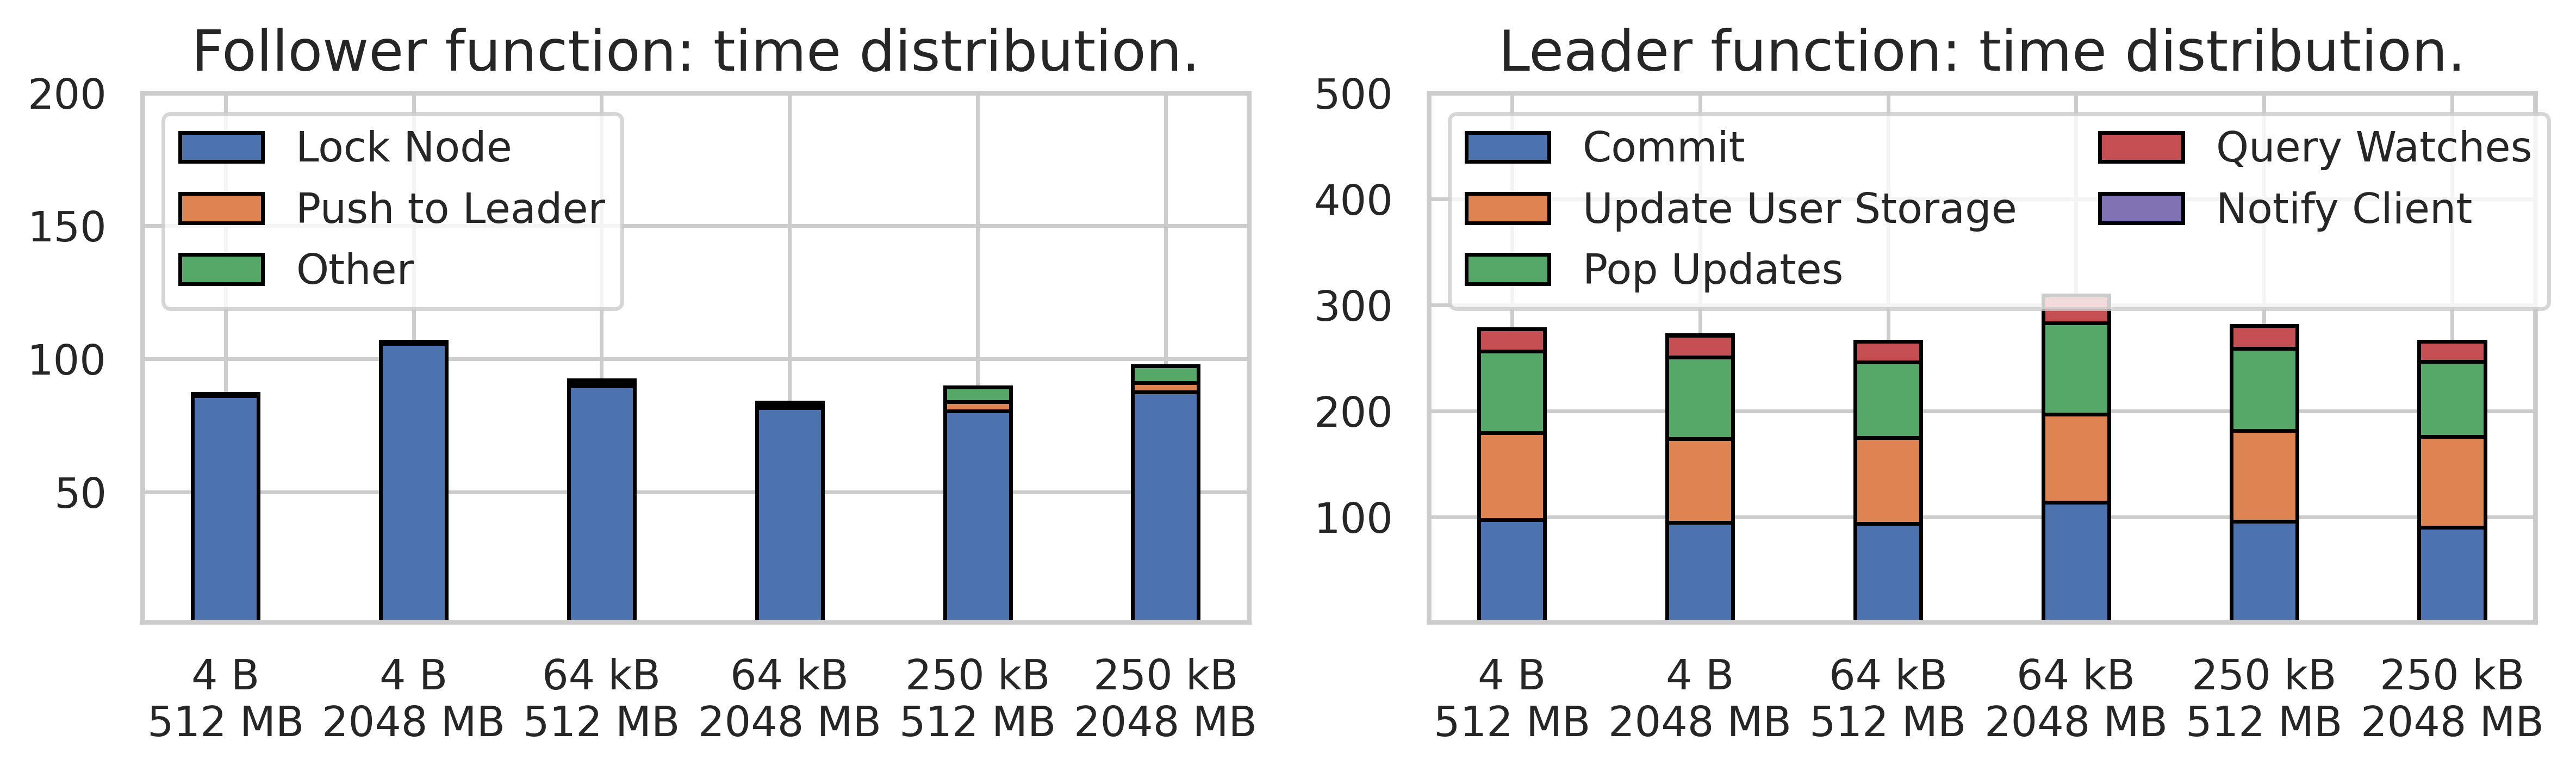

In [29]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats
from os.path import join, pardir

DATA_DIR = join(pardir, pardir, 'data', 'read')

#sns.set(rc={'figure.figsize':(16,8)})
sns.set(rc={'figure.figsize':(10,3)})
sns.set_style("whitegrid")

fig3 = plt.figure(constrained_layout=True)
gs = fig3.add_gridspec(1,4)
barplot = fig3.add_subplot(gs[0,0:2])
barplot_distr = fig3.add_subplot(gs[0,2:4])

width = 0.35       # the width of the bars: can also be len(x) sequence
sum_ = [0,0,0,0,0,0]
labels = ['4 B\n512 MB', '4 B\n2048 MB', '64 kB\n512 MB', '64 kB\n2048 MB', '250 kB\n512 MB', '250 kB\n2048 MB']
#for id, col in enumerate(['Lock Node', 'Commit and Unlock', 'Push to Distributor', 'Other']):
for id, col in enumerate(['Lock Node', 'Push to Leader', 'Other']):

    print(barplot_data_writer[id])
    barplot.bar(labels, barplot_data_writer[id], width, label=col, bottom=sum_, edgecolor='black')
    sum_ = np.add(sum_, barplot_data_writer[id])
barplot.legend()

barplot.legend(loc='upper left')
barplot.set_ylim(1, 200)
barplot.set_title('Follower function: time distribution.', fontsize=15)


width = 0.35       # the width of the bars: can also be len(x) sequence
sum_ = [0,0,0,0,0,0]
labels = ['4 B\n512 MB', '4 B\n2048 MB', '64 kB\n512 MB', '64 kB\n2048 MB', '250 kB\n512 MB', '250 kB\n2048 MB']
#for id, col in enumerate(['Update User Storage', 'Pop Updates', 'Query Watches', 'Notify Client', 'Other']):
for id, col in enumerate(['Commit', 'Update User Storage', 'Pop Updates', 'Query Watches', 'Notify Client']):


    #print(barplot_data[id])
    barplot_distr.bar(labels, barplot_data_distributor[id], width, label=col, bottom=sum_, edgecolor='black')
    sum_ = np.add(sum_, barplot_data_distributor[id])
barplot_distr.legend(loc='upper left',ncol=2)
barplot_distr.set_ylim(1, 500)

barplot_distr.set_title('Leader function: time distribution.', fontsize=15)

plt.rcParams['figure.dpi'] = 500
plt.tight_layout()
plt.savefig("gcp_plot_distribution.pdf",bbox_inches='tight',pad_inches = 0, transparent=False)

In [21]:
DATA_DIR = join(pardir, pardir, 'data', 'write', 'gcp_cloud_storage')
dfs = []
import ast
# lock atomic commit push rest
#barplot_data = [[],[],[],[],[]]
#barplot_stds = [[],[],[],[],[],[]]
#for size in [4, 1024, 65536, 131072, 256000]:


full_data = []
for size in [4, 65536, 262144]:
    
    for memory in [512, 2048]:
    #for memory in [512]:
        
        with open(join(DATA_DIR, f'persistent_{size}_{memory}.timings')) as in_f:
                  
            writer = False
            for line in in_f:
                
                #print(line.split(':')[2])
                key = line.split(':')[1].split()[0].strip()
                if key == 'total':
                    key = f'{key}_writer' if not writer else f'{key}_distributor'
                    writer = True
                data = ast.literal_eval(line.split(':')[2])
                for val in data:
                    full_data.append([int(size), int(memory), key, val])
        

timings_df = pd.DataFrame(data=full_data, columns=['size', 'memory', 'key', 'value']) 
timings_df['value'] *= 1000
print(timings_df['key'].unique())
#size = 4
#memory = 512
#df = pd.read_csv(join(DATA_DIR, f'persistent_{size}_summary.csv'),index_col=None)
#df['size'] = size / 1024.0
#df['value'] *= 1000.0
#df['value'] /= df['repetitions']
#print(df.loc[(df['memory'] == memory) & (df['function'] == 'writer')])

#barplot_data[0].append(df.loc[(df['memory'] == memory) & (df['function'] == 'writer') & (df['type'] == 'lock')]['value'].values[0])
#barplot_data[1].append(df.loc[(df['memory'] == memory) & (df['function'] == 'writer') & (df['type'] == 'atomic')]['value'].values[0])
#barplot_data[2].append(df.loc[(df['memory'] == memory) & (df['function'] == 'writer') & (df['type'] == 'commit')]['value'].values[0])
#barplot_data[3].append(df.loc[(df['memory'] == memory) & (df['function'] == 'writer') & (df['type'] == 'push')]['value'].values[0])
#total = df.loc[(df['memory'] == memory) & (df['function'] == 'writer') & (df['type'] == 'total')]['value'].values[0]
#barplot_data[4].append(
#    total
#    - barplot_data[0][-1] - barplot_data[1][-1] - barplot_data[2][-1] - barplot_data[3][-1]
#)
barplot_data_writer = [[],[],[]]


#for size in [4, 65536, 256000]:
for size in [4, 65536, 262144]:
    
    for memory in [512, 2048]:
        
        barplot_data_writer[0].append(
            timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'lock')]['value'].median()
        )
        #barplot_data_writer[1].append(timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size)& (timings_df['key'] == 'commit')]['value'].median())
        barplot_data_writer[1].append(timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size)& (timings_df['key'] == 'push')]['value'].median())

        total = timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size)& (timings_df['key'] == 'total_writer')]['value'].median()
        #print(total)
        barplot_data_writer[2].append(
            total
            - barplot_data_writer[0][-1] - barplot_data_writer[1][-1] #- barplot_data_writer[2][-1]
        )
        
barplot_data_distributor = [[],[],[],[],[],[]]


#for size in [4, 65536, 256000]:
for size in [4, 65536, 262144]:
    
    for memory in [512, 2048]:
        
        #barplot_data_distributor[0].append(
        #    #timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'exec_read')]['value'].median()
        #    + timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'commit')]['value'].median()
        #    + timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'exec_update')]['value'].median()
        #)
        barplot_data_distributor[0].append(
            #timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'exec_read')]['value'].median()
            timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'commit')]['value'].median()
        )
        barplot_data_distributor[1].append(
            + timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'exec_update')]['value'].median()
        )
        #barplot_data_distributor[1].append(
        #    timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'exec_update')]['value'].median()
        #)
        barplot_data_distributor[2].append(
            timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size) & (timings_df['key'] == 'exec_pop_updates')]['value'].median()
        )
        barplot_data_distributor[3].append(timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size)& (timings_df['key'] == 'watch_query')]['value'].median())
        barplot_data_distributor[4].append(timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size)& (timings_df['key'] == 'notify')]['value'].median())

        total = timings_df.loc[(timings_df['memory'] == memory) & (timings_df['size'] == size)& (timings_df['key'] == 'total_distributor')]['value'].median()
        #print(total)
        barplot_data_distributor[5].append(
            total
            - barplot_data_distributor[0][-1] - barplot_data_distributor[1][-1] - barplot_data_distributor[2][-1] - barplot_data_distributor[3][-1]- barplot_data_distributor[4][-1]
        )

['lock' 'push' 'total_writer' 'parse' 'write' 'watch_query' 'notify'
 'total_distributor' 'exec_update' 'exec_pop_updates' 'commit']


In [18]:
print(barplot_data_writer)
print(barplot_data_distributor)

[[86.18712425231934, 105.65698146820068, 89.80333805084229, 81.55477046966553, 80.39307594299316, 87.6246690750122], [0.6052255630493164, 0.6015300750732422, 0.8827447891235352, 0.8476972579956055, 3.3718347549438477, 3.341555595397949], [0.2065896987915039, 0.22876262664794922, 1.3794898986816406, 1.3424158096313477, 5.639076232910156, 6.358146667480469]]
[[179.38482761383057, 173.82943630218506, 174.69894886016846, 196.99668884277344, 181.60152435302734, 175.96018314361572], [76.83944702148438, 76.79808139801025, 71.58315181732178, 85.81781387329102, 77.29673385620117, 70.47200202941895], [21.260619163513184, 20.90466022491455, 19.3939208984375, 26.301860809326172, 21.472573280334473, 19.22297477722168], [0.17213821411132812, 0.16355514526367188, 0.1710653305053711, 0.1691579818725586, 0.20635128021240234, 0.16570091247558594], [10.854959487915039, 4.7980546951293945, 3.8046836853027344, 3.3904314041137695, 11.591553688049316, 15.379071235656738]]
